# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from tqdm import notebook, trange

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

The basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer.

## Exploratory Data Analysis

In [2]:
print(len(portfolio))
print(len(profile))
print(len(transcript))

10
17000
306534


In [3]:
print('portfolio shape is', portfolio.shape)
portfolio

portfolio shape is (10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
print('transcript shape is', transcript.shape)
transcript.sample(9)

transcript shape is (306534, 4)


,person,event,value,time
28235,a4d4393d96a3456bb68a434973ad9b47,transaction,{'amount': 0.9400000000000001},42
44524,eba8d696316d42be9837b38f908db3ac,transaction,{'amount': 12.2},114
216030,a14d4f2ec359464f8d4aeac17b755903,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},504
71782,99a0115e5cfa468aa139f2be4e5437c2,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},174
78380,d80115e2c3fa4b2fa68c65199e7dbb83,transaction,{'amount': 13.56},192
57736,c801141ccbd74cb08db4b93cc5917a1e,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},168
215310,3347e6cc276f45d6b7a3b18e955f7bb9,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},504
238495,5ccc9ec750834277812d9a81d44debb7,transaction,{'amount': 8.96},552
112614,290cdbe5173940758a689238b72f80b0,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},336


In [5]:
print('profile shape is', profile.shape)
profile.head()

profile shape is (17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


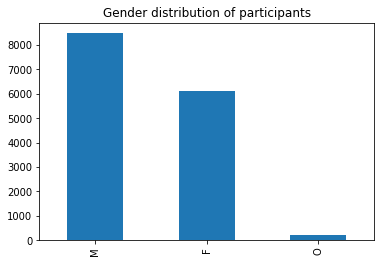

In [6]:

profile.gender.value_counts().plot(kind='bar')
plt.title('Gender distribution of participants');

In [7]:
profile.gender.isna().sum()

2175

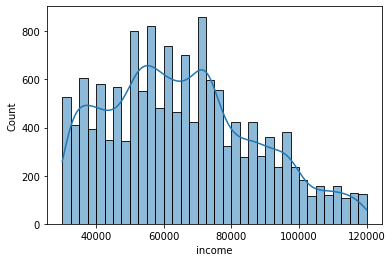

In [8]:
sns.histplot(profile.income, kde=True);

In [9]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [10]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [11]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [12]:
from datetime import datetime

In [13]:
profile['became_member_on'] = profile.became_member_on.astype(str)

In [14]:
# change date column to datetime
profile['became_member_on'] = profile.became_member_on.apply(lambda s: datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8])))
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [15]:
cols = ['web', 'email', 'mobile', 'social']
for col in cols:
    portfolio[col] = portfolio.channels.apply(lambda x: int(col in x))
portfolio

,reward,channels,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [16]:
def to_list(dict_):
    import pandas as pd
    lst = []
    for i,j in dict_.items():
        temp = [i,j]
        lst.extend(temp)
    return pd.Series({'type': lst[0], 'id' : lst[1]})


In [17]:
%%time
transcript.loc[:,['type', 'id']] = transcript.value.apply(to_list)
del transcript['value']
transcript.sample(5)

Wall time: 1min 32s


,person,event,time,type,id
195161,1edf0aed2dcf4efc93a419a7535d5744,transaction,480,amount,12.54
247190,77b27d5f09db42cf9c844ab58d132e85,offer received,576,offer id,fafdcd668e3743c1bb461111dcafc2a4
244242,abd6e8f0ea7d4f0f877e1683213dabb9,transaction,570,amount,9.45
264859,d56d701948d7473d80c0583ca8221eef,offer viewed,582,offer id,fafdcd668e3743c1bb461111dcafc2a4
33495,cbae907907b740f5a26e9a63fc39facb,transaction,60,amount,9.4


In [18]:

amt_spent = transcript[transcript.event == 'transaction'].groupby('person', as_index=False)['id'].sum()
amt_spent.columns = ['person','amount']
print(len(amt_spent))
amt_spent.head()

16578


,person,amount
0,0009655768c64bdeb2e877511632db8f,127.60
1,00116118485d4dfda04fdbaba9a87b5c,4.09
2,0011e0d4e6b944f998e987f904e8c1e5,79.46
3,0020c2b971eb4e9188eac86d93036a77,196.86
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05


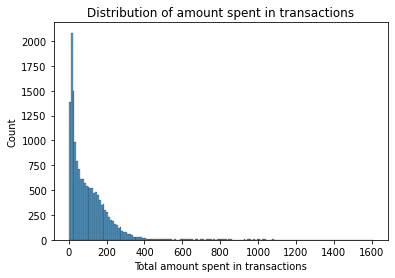

In [19]:
# not everyone in the population made a transaction
sns.histplot(amt_spent.amount)
plt.xlabel('Total amount spent in transactions')
plt.title('Distribution of amount spent in transactions');

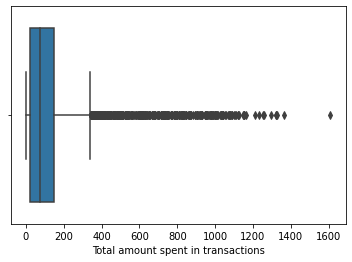

In [20]:
sns.boxplot(x=amt_spent.amount)
plt.xlabel('Total amount spent in transactions');

In [21]:
# most of the participants spent 400 and below over the test period.
# Using a cut-off of 400, see how many of those below and above this threshold view an offer and also complete an offer

In [22]:
del portfolio['channels']
portfolio

,reward,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [23]:
portfolio['offer_detail'] = portfolio[portfolio.columns[:4]].apply(lambda x: ''.join(x.astype(str)), axis=1)
portfolio

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,offer_detail
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,10107bogo
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,10105bogo
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,004informational
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,557bogo
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,52010discount
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,377discount
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,21010discount
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,003informational
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,555bogo
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,2107discount


In [24]:
profile.rename(columns={'id':'person'}, inplace=True)
profile.head()

,gender,age,person,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [25]:
portfolio_less_info = portfolio[portfolio.offer_type != 'informational']
final_data = transcript.merge(portfolio_less_info, on='id', how='left')

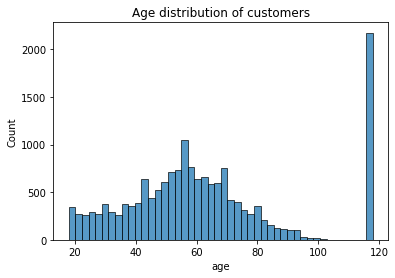

In [26]:
# remove outliers and check if model gets better for it
sns.histplot(profile.age)
plt.title('Age distribution of customers');

In [27]:
outliers = profile[profile.age > 105]
print(len(outliers))
outliers.sample(5)

2175


,gender,age,person,became_member_on,income
7540,None,118,680fa93d47c14cac99128972256f9265,2017-09-15,NaN
12599,None,118,6b8dc8557ff1444da47b271bb0c2c73d,2016-02-23,NaN
143,None,118,58748c1cf9f746838c6ec62acdff28ad,2016-10-18,NaN
3564,None,118,3cbbefdc6db148d88acf8944bd77c48d,2016-07-12,NaN
14380,None,118,09d8cabe7017456da71f0a8fb4bf4b3d,2018-01-19,NaN


In [28]:
transcript[transcript.person.isin(outliers.person)].event.value_counts()/transcript[transcript.person.isin(outliers.person)].shape[0]

transaction        0.444036
offer received     0.289471
offer viewed       0.232885
offer completed    0.033608
Name: event, dtype: float64

In [29]:
transcript[~transcript.person.isin(outliers.person)].event.value_counts()/transcript[~transcript.person.isin(outliers.person)].shape[0]

transaction        0.454451
offer received     0.243806
offer viewed       0.182797
offer completed    0.118946
Name: event, dtype: float64

#### How do you interprete the above?

In [30]:
def grp_stat(df):
    """
    returns % of offer viewed and offer completed out of the total offers received.
    
    """
    stat =df.event.value_counts()
    try:
        offer_viewed = round(stat['offer viewed']/stat['offer received'], 2)
    except KeyError:
        offer_viewed = 0
    try:
        offer_completed = round(stat['offer completed']/stat['offer received'], 2)
    except KeyError:
        offer_completed = 0
    return pd.Series({'viewed_perc': offer_viewed,
                     'completed_perc': offer_completed})

In [31]:
print(len(final_data))
offer_stat = final_data.groupby(['person','offer_detail'],as_index=False).apply(grp_stat)
print(len(offer_stat))
offer_stat.head()

306534
50637


,person,offer_detail,viewed_perc,completed_perc
0,0009655768c64bdeb2e877511632db8f,21010discount,1.0,1.0
1,0009655768c64bdeb2e877511632db8f,2107discount,0.0,1.0
2,0009655768c64bdeb2e877511632db8f,555bogo,1.0,1.0
3,00116118485d4dfda04fdbaba9a87b5c,555bogo,1.0,0.0
4,0011e0d4e6b944f998e987f904e8c1e5,377discount,1.0,1.0


In [32]:
offer_stats = offer_stat.merge(amt_spent, on = 'person', how = 'left')
offer_stats['amount_bin'] = np.where(offer_stats.amount > 400, 'above_400', 'below_400')
offer_stats.isna().sum()

person               0
offer_detail         0
viewed_perc          0
completed_perc       0
amount            1271
amount_bin           0
dtype: int64

In [33]:
offer_stats_grp = offer_stats.dropna(subset='amount').groupby([ 'offer_detail','amount_bin'], as_index=False).agg({'viewed_perc':'mean','completed_perc':'mean'})
offer_stats_grp

,offer_detail,amount_bin,viewed_perc,completed_perc
0,10105bogo,above_400,0.974074,0.874074
1,10105bogo,below_400,0.960657,0.438303
2,10107bogo,above_400,0.877727,0.910714
3,10107bogo,below_400,0.879822,0.481969
4,21010discount,above_400,0.981595,0.978528
5,21010discount,below_400,0.964924,0.709810
6,2107discount,above_400,0.715564,0.909774
7,2107discount,below_400,0.531717,0.534725
8,377discount,above_400,0.954130,0.927536
9,377discount,below_400,0.960470,0.686808


Offers with the highest difficulty have the lowest completion rate even when they have a high view rate.

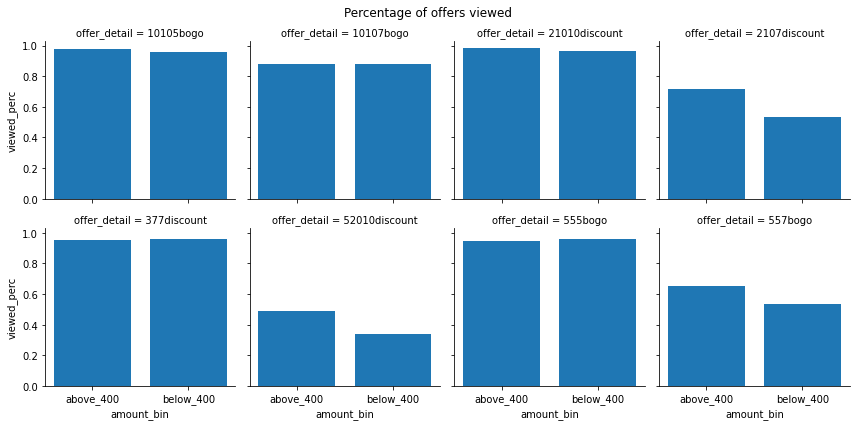

In [34]:
g = sns.FacetGrid(offer_stats_grp, col="offer_detail", col_wrap=4)
g.map_dataframe(plt.bar,'amount_bin',"viewed_perc")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Percentage of offers viewed');

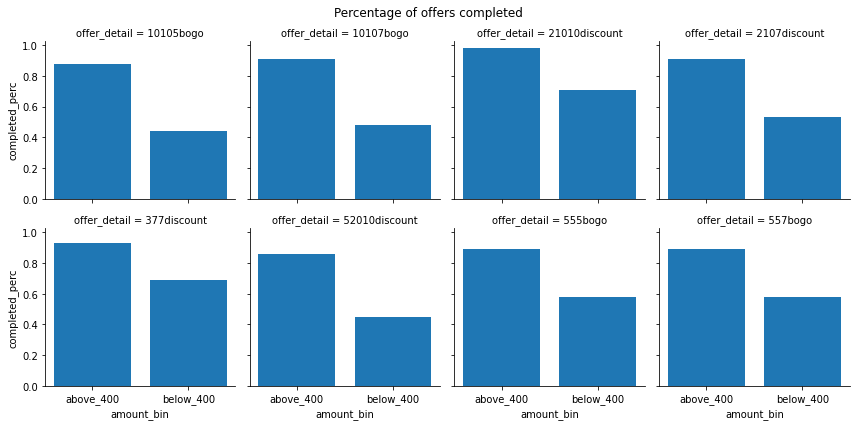

In [35]:
g = sns.FacetGrid(offer_stats_grp, col="offer_detail", col_wrap=4)
g.map_dataframe(plt.bar,'amount_bin',"completed_perc")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Percentage of offers completed');

The largest disparity in completion is at 10105,10107 and 52010. These are the offers with the highest difficulty level.

In [36]:
amt_spent.head()

,person,amount
0,0009655768c64bdeb2e877511632db8f,127.60
1,00116118485d4dfda04fdbaba9a87b5c,4.09
2,0011e0d4e6b944f998e987f904e8c1e5,79.46
3,0020c2b971eb4e9188eac86d93036a77,196.86
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05


In [37]:
profile.head()

,gender,age,person,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [38]:
amt_income = profile.dropna(subset='income').merge(amt_spent.dropna(subset='amount'), left_on='person', right_on='person', how='inner')
print(len(amt_income))
amt_income.head()

14492


,gender,age,person,became_member_on,income,amount
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,77.01
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,159.27
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,57.73
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,36.43
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,15.62


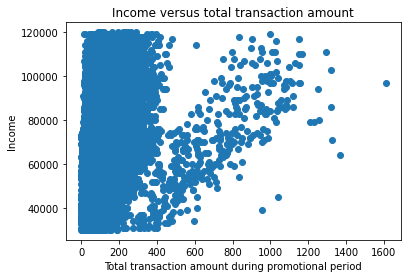

In [39]:
plt.scatter(x=amt_income.amount, y=amt_income.income)
plt.xlabel('Total transaction amount during promotional period')
plt.ylabel('Income')
plt.title('Income versus total transaction amount');

Up until a total spend of 400, it is equally likely for every participant to spend between 0 and 400 regardless of their income. However, total money spent linearly increases with income beyond a total transaction amount of 400.

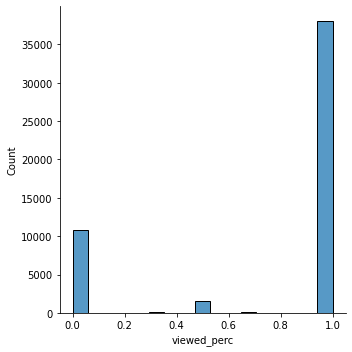

In [40]:
sns.displot(offer_stat.viewed_perc)

In [41]:
def bin_data(x,name):
    if x == 0:
        return 'low_{}'.format(name)
    elif x == 1:
        return 'high_{}'.format(name)
    else:
        return 'mid_{}'.format(name)

In [42]:
offer_stat['view'] = offer_stat.viewed_perc.apply(lambda x: bin_data(x,name='view'))
offer_stat.sample(10)

,person,offer_detail,viewed_perc,completed_perc,view
38611,c1e6f72a430044bd9ba700bd7266aba6,377discount,1.0,1.0,high_view
387,0215efe5136d4a038cb81eae92d59368,21010discount,1.0,1.0,high_view
22371,70f0cba2dfeb48d2817d789ba39b1939,10107bogo,1.0,1.0,high_view
49091,f86637beefb14808bc830ac1443a09e9,557bogo,0.0,0.0,low_view
43714,dc686916a51a4496bf4224ba4266a4f1,52010discount,0.0,1.0,low_view
16172,51d24a88e6fb4395b670ec41ab687ad2,2107discount,0.0,0.0,low_view
25863,829a8d14daf34f9299b21440c085ff49,21010discount,1.0,1.0,high_view
22323,70a5c4916ce045de9ebd71a7c49668c3,10105bogo,0.0,1.0,low_view
15289,4d5618b1bd0c4d1693b860e5b4daac40,10105bogo,1.0,0.0,high_view
29000,91b419fb52ef43dfa38d8ac1a8c95bec,557bogo,1.0,0.0,high_view


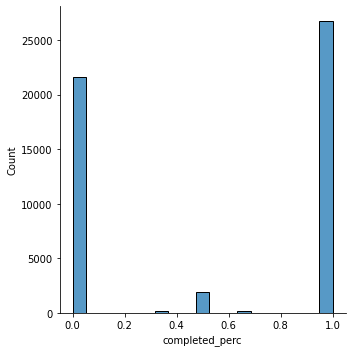

In [43]:
sns.displot(offer_stat.completed_perc)

In [44]:
offer_stat['complete'] = offer_stat.completed_perc.apply(lambda x: bin_data(x,name='complete'))
offer_stat.sample(5)

,person,offer_detail,viewed_perc,completed_perc,view,complete
4016,14b3c3a8b314464a9daf8354ed6dd560,557bogo,0.0,0.0,low_view,low_complete
37882,bde862d5e203492bacf656c8bddcead5,555bogo,1.0,1.0,high_view,high_complete
23757,780896df71d247de8ab23edd1201d34d,10105bogo,1.0,0.0,high_view,low_complete
36376,b66473610fa74072a1345b6c93d52464,52010discount,1.0,1.0,high_view,high_complete
4775,18f2f42d216c4f499f0e7896945236ca,52010discount,0.0,1.0,low_view,high_complete


In [45]:
offer_stat.groupby(['view','complete'], as_index=False).agg({'person':'count', 'offer_detail': [lambda x: x.value_counts().index[0],lambda x: x.value_counts()[0]]})

view       complete person   offer_detail           
                             count     <lambda_0> <lambda_1>
0  high_view  high_complete  21835  21010discount       4178
1  high_view   low_complete  14829      10105bogo       3253
2  high_view   mid_complete   1384        555bogo        318
3   low_view  high_complete   4206  52010discount       1376
4   low_view   low_complete   6275  52010discount       2468
5   low_view   mid_complete    330  52010discount        130
6   mid_view  high_complete    711        557bogo        180
7   mid_view   low_complete    537   2107discount        123
8   mid_view   mid_complete    530        557bogo        146

#### Mode values analysis
1. No high complete is less than 7 days
2. No low complete has difficulty less than 10
3. reward of all mid-complete is 5
4. all the low view have difficulty of 20
------> Check the demography too

In [46]:
all_data = offer_stat.merge(profile, on = 'person', how = 'left')
print(len(all_data))
all_data.head()

50637


,person,offer_detail,viewed_perc,completed_perc,view,complete,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,21010discount,1.0,1.0,high_view,high_complete,M,33,2017-04-21,72000.0
1,0009655768c64bdeb2e877511632db8f,2107discount,0.0,1.0,low_view,high_complete,M,33,2017-04-21,72000.0
2,0009655768c64bdeb2e877511632db8f,555bogo,1.0,1.0,high_view,high_complete,M,33,2017-04-21,72000.0
3,00116118485d4dfda04fdbaba9a87b5c,555bogo,1.0,0.0,high_view,low_complete,None,118,2018-04-25,NaN
4,0011e0d4e6b944f998e987f904e8c1e5,377discount,1.0,1.0,high_view,high_complete,O,40,2018-01-09,57000.0


age and income distribution facet by view and complete

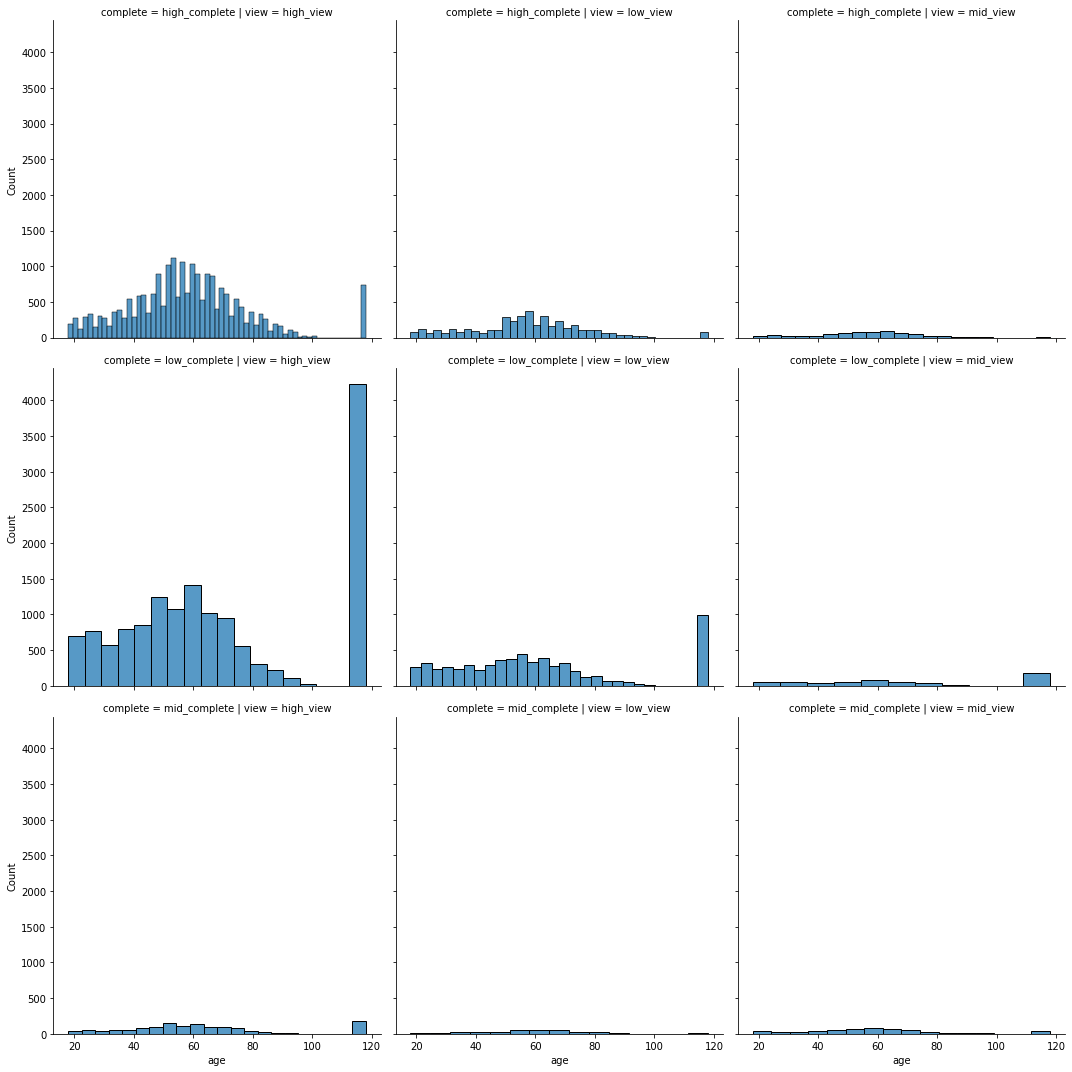

In [47]:
g = sns.FacetGrid(all_data, col="view",  row="complete", height=5)
g.map_dataframe(sns.histplot, x="age");

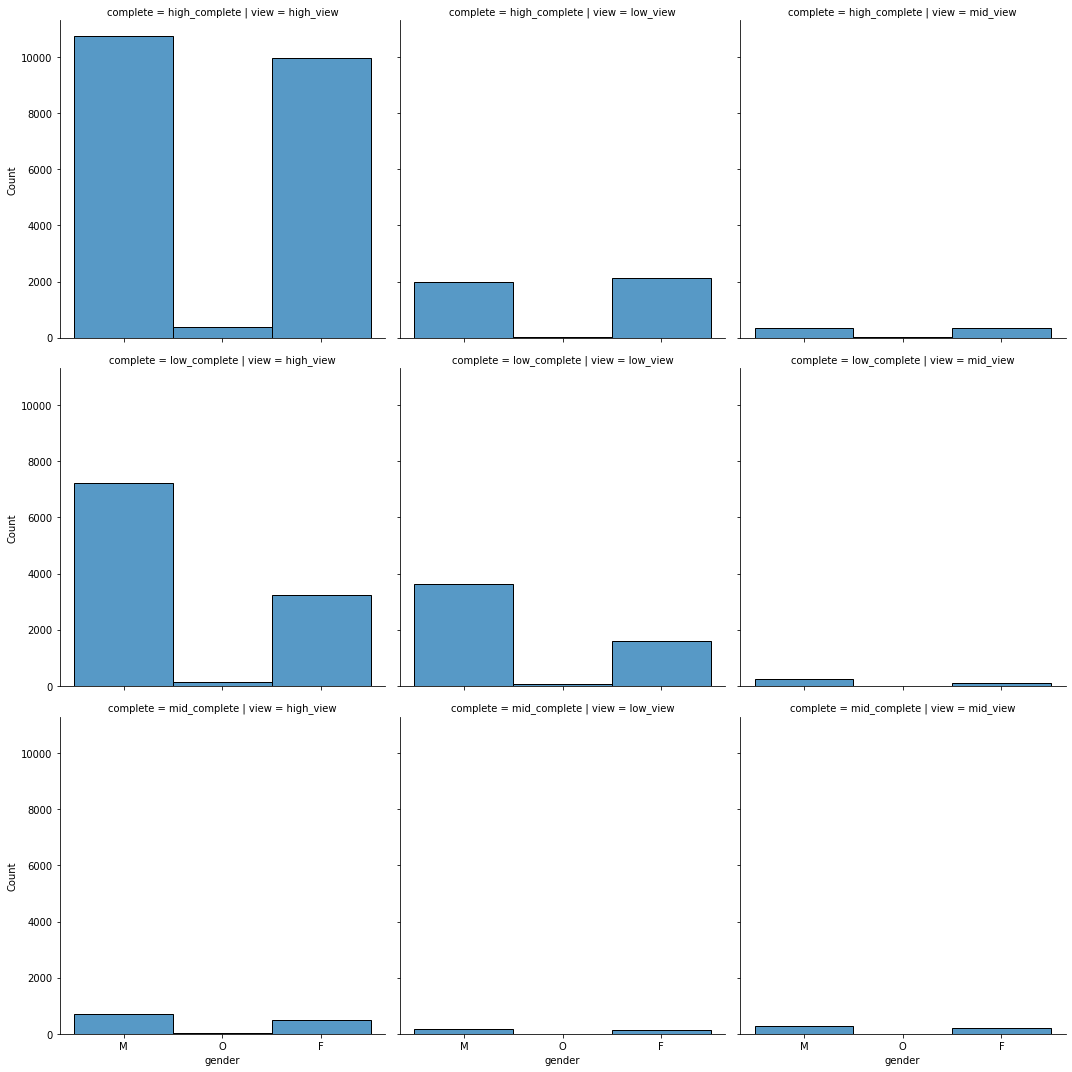

In [48]:
g = sns.FacetGrid(all_data, col="view",  row="complete", height=5)
g.map_dataframe(sns.histplot, x="gender");

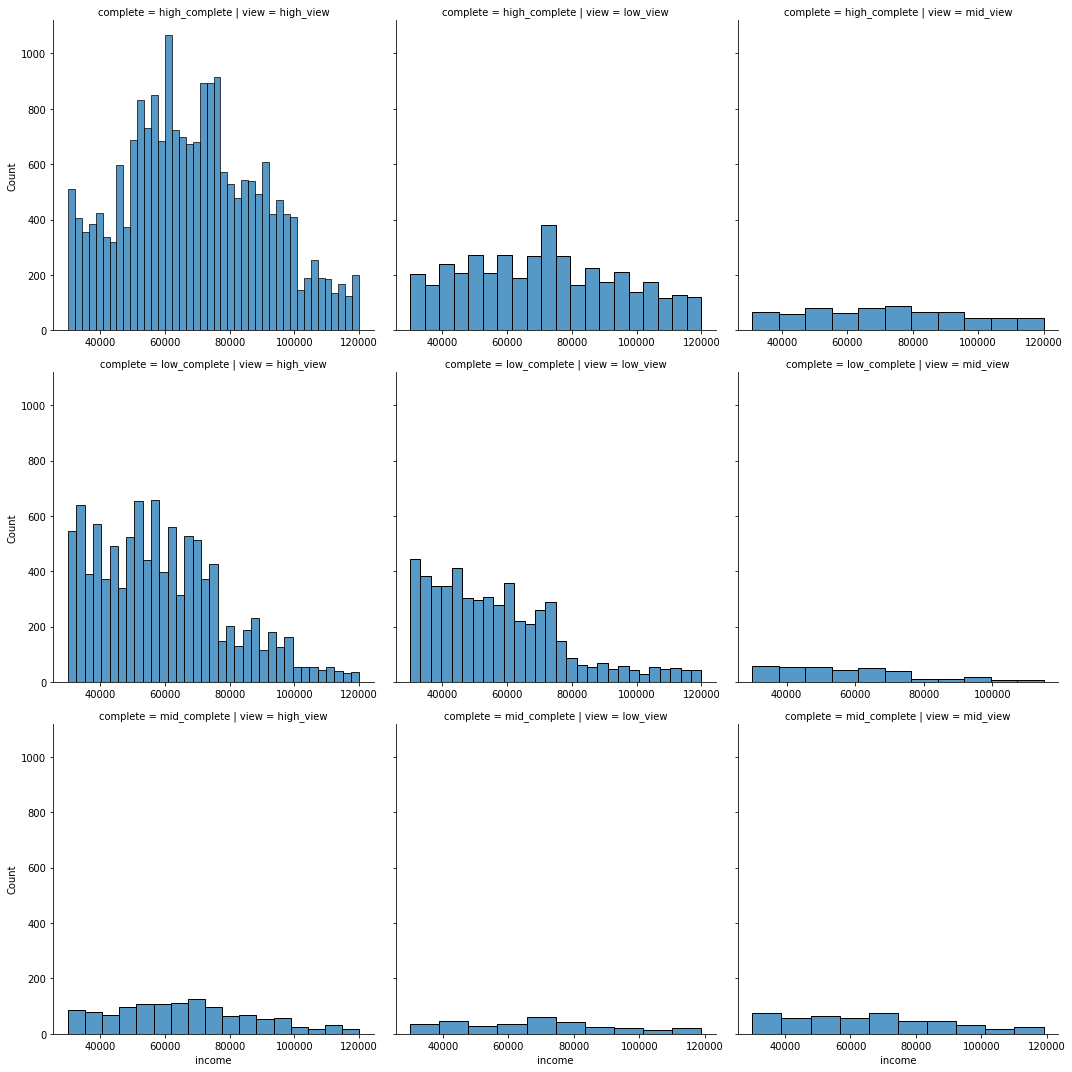

In [49]:
g = sns.FacetGrid(all_data, col="view",  row="complete", height=5, sharex=False)
g.map_dataframe(sns.histplot, x="income");

In [50]:
offer_stat.completed_perc.value_counts()

1.00    26752
0.00    21641
0.50     1921
0.67      154
0.33      152
0.75        9
0.25        5
0.60        1
0.20        1
0.40        1
Name: completed_perc, dtype: int64

In [51]:
offer_stat.viewed_perc.value_counts()

1.00    38048
0.00    10811
0.50     1524
0.67      138
0.33      104
0.75        7
0.25        4
0.20        1
Name: viewed_perc, dtype: int64

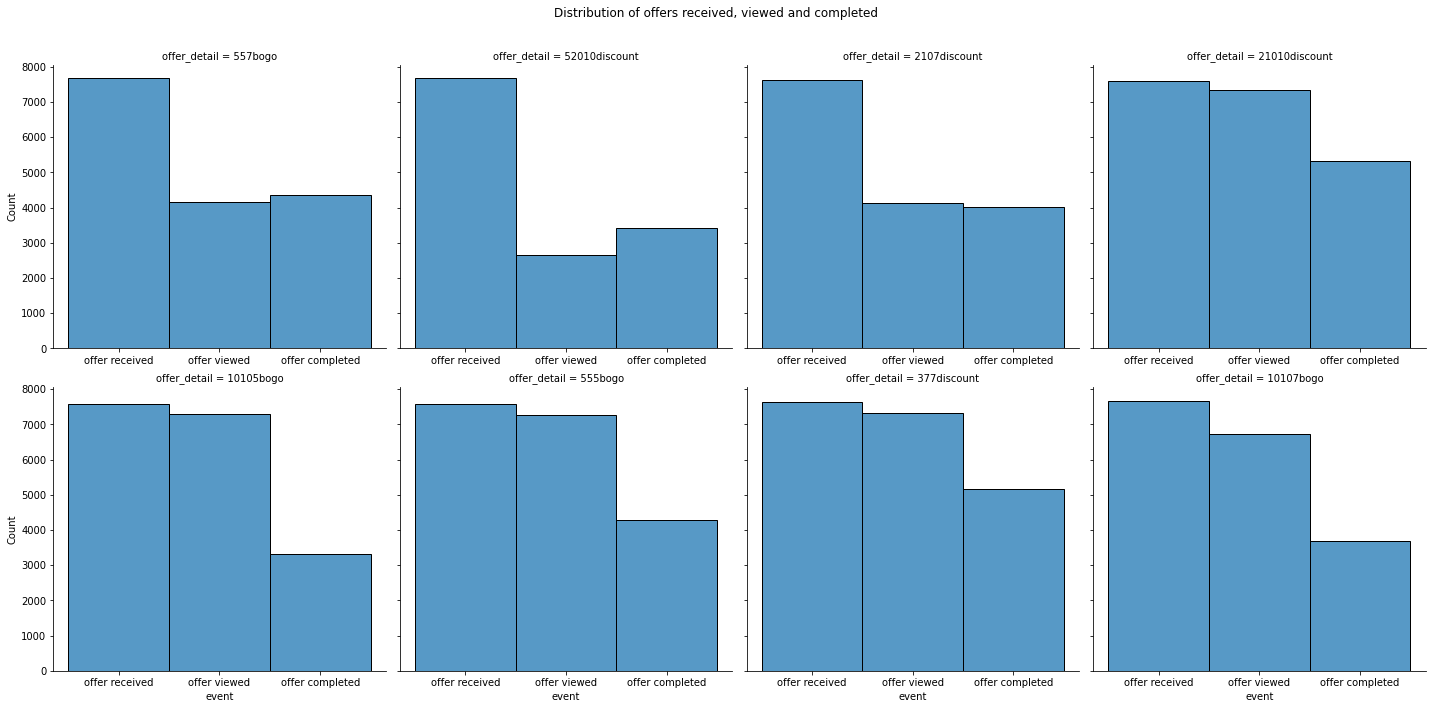

In [52]:
g = sns.FacetGrid(final_data, col="offer_detail", height=5, sharex=False, col_wrap=4)
g.map_dataframe(sns.histplot, x="event")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of offers received, viewed and completed');

only 2 were completed more than viewed

## Modeling

In [53]:
final_data.head()

,person,event,time,type,id,reward,difficulty,duration,offer_type,web,email,mobile,social,offer_detail
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,557bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,52010discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,2107discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,21010discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,10105bogo


In [54]:
#final_data = final_data[~final_data.id.isin(['3f207df678b143eea3cee63160fa8bed','5a8bc65990b245e5a138643cd4eb9837'])]

idx = round(0.85 * len(final_data))
data = final_data[['person', 'event', 'offer_detail']]
train_data = data.iloc[:idx,]
test_data = data.iloc[idx:,]

train_data_df = train_data.groupby(['person','offer_detail'], as_index=False).agg({'event': lambda x: sum(x=='offer completed')})
test_data_df = test_data.groupby(['person','offer_detail'], as_index=False).agg({'event': lambda x: sum(x=='offer completed')})


In [55]:
person_offer_df = train_data_df.groupby(['person','offer_detail'])['event'].max().astype(bool).astype(int).unstack()
person_offer_df_test = test_data_df.groupby(['person','offer_detail'])['event'].max().astype(bool).astype(int).unstack()

person_offer_df.head()

offer_detail,10105bogo,10107bogo,21010discount,2107discount,377discount,52010discount,555bogo,557bogo
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0
0020c2b971eb4e9188eac86d93036a77,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0


In [56]:
person_offer_mat = person_offer_df.values
person_offer_mat_test = person_offer_df_test.values

In [57]:
def FunkSVD(ratings_mat, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, movies as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0] # number of rows in the matrix
    n_movies = ratings_mat.shape[1] # number of movies in the matrix
    num_ratings = n_users * n_movies # total number of ratings in the matrix
    
    # initialize the user and movie matrices with random values
    # helpful link: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.rand.html
    user_mat = np.random.rand(n_users,latent_features) # user matrix filled with random values of shape user x latent 
    movie_mat = np.random.rand(latent_features, n_movies) # movie matrix filled with random values of shape latent x movies
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for i in notebook.trange(iters):
        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-movie pair
        for j in range(num_ratings):
            row = j//n_movies
            col = j%n_movies
                # if the rating exists
            if not np.isnan(ratings_mat[row,col]): 
                    # compute the error as the actual minus the dot product of the user and movie latent features
                error = ratings_mat[row,col] - np.dot(user_mat[row,:], movie_mat[:,col])
                    # Keep track of the total sum of squared errors for the matrix
                sse_accum += error**2
                    # update the values in each matrix in the direction of the gradient
                for k in range(latent_features):
                    user_mat[row,k] += 2*learning_rate*movie_mat[k,col]*error
                    movie_mat[k,col] += 2*learning_rate*user_mat[row,k]*error # try and update movie_mat after all user_mat is updated and see if it changes anything
        # print results for iteration
        print(i, '|', sse_accum)
        if i == 3000:
            learning_rate = learning_rate*2
    return user_mat, movie_mat 

In [ ]:
person_mat, offer_mat = FunkSVD(person_offer_mat, latent_features=15, learning_rate=0.001, iters=3000)

Optimization Statistics
Iterations | Mean Squared Error 


  0%|          | 0/3000 [00:00<?, ?it/s]

0 | 21361.561617256335
1 | 12838.084515853336
2 | 12609.341063962864
3 | 12577.804628185282
4 | 12569.577576848285
5 | 12564.049754613716
6 | 12558.807076796398
7 | 12553.582374806667
8 | 12548.352375273065
9 | 12543.117565316552
10 | 12537.879177760748
11 | 12532.637756037597
12 | 12527.393476943753
13 | 12522.146370089153
14 | 12516.896409646657
15 | 12511.64354898544
16 | 12506.387733357598
17 | 12501.12890450037
18 | 12495.86700230216
19 | 12490.601965395264
20 | 12485.333731368122
21 | 12480.062236831554
22 | 12474.78741743562
23 | 12469.509207866391
24 | 12464.227541837516
25 | 12458.942352077142
26 | 12453.65357031517
27 | 12448.36112726871
28 | 12443.064952628478
29 | 12437.76497504396
30 | 12432.46112210897
31 | 12427.1533203467
32 | 12421.84149519557
33 | 12416.525570992631
34 | 12411.205470958694
35 | 12405.881117183246
36 | 12400.552430608244
37 | 12395.219331012051
38 | 12389.881736992786
39 | 12384.539565953633
40 | 12379.192734083495
41 | 12373.84115634304
42 | 12368.484

336 | 9417.212395856359
337 | 9396.089768832993
338 | 9374.868840229557
339 | 9353.55046260303
340 | 9332.135516098126
341 | 9310.62490831719
342 | 9289.019574172486
343 | 9267.320475720002
344 | 9245.528601972464
345 | 9223.644968697587
346 | 9201.67061819255
347 | 9179.606619045162
348 | 9157.454065871703
349 | 9135.214079038886
350 | 9112.887804365651
351 | 9090.47641280854
352 | 9067.981100124967
353 | 9045.403086523042
354 | 9022.74361628897
355 | 9000.003957398729
356 | 8977.185401112753
357 | 8954.289261550135
358 | 8931.316875248713
359 | 8908.269600707246
360 | 8885.148817909308
361 | 8861.955927833369
362 | 8838.692351945014
363 | 8815.359531674523
364 | 8791.95892787866
365 | 8768.492020288038
366 | 8744.960306939334
367 | 8721.36530359469
368 | 8697.70854314607
369 | 8673.991575008458
370 | 8650.215964498457
371 | 8626.383292202932
372 | 8602.495153333992
373 | 8578.553157075328
374 | 8554.55892591634
375 | 8530.51409497732
376 | 8506.42031132554
377 | 8482.279233281868
378

In [ ]:
num_latent_feats = np.arange(2,15,1)
sum_errs = []

for i in notebook.trange(len(num_latent_feats)):
    k = num_latent_feats[i]
    # restructure with k latent features
    u_new, vt_new = person_mat[:, :k], offer_mat[:k, :]
    
    # take dot product
    person_offer_est = np.around(np.dot(u_new, vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.nansum(np.subtract(person_offer_mat, person_offer_est))
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
n_notna = (~np.isnan(person_offer_mat)).sum()
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(n_notna));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

### When 0 is in the test set

In [ ]:
person_offer_df.sample(5)

In [ ]:
person_offer_df_test[person_offer_df_test.index == '42e511d82add46d4b0038ab71015f1b5']

In [ ]:
row = np.where(person_offer_df.index=='42e511d82add46d4b0038ab71015f1b5')[0][0]
np.around(np.dot(person_mat[row, :7], offer_mat[:7,])).astype(bool).astype(int)

The occurrence of 0 for an offer in the test set always force the prediction to zero in the test set. This makes sense because the algorithm tries to reproduce the observed values in the training examples while imputing the missing values. However, this affects the actual prediction on the test set because the fact that a customer did not complete an offer in the past does not mean such will not complete the same offer in the future.

In [ ]:
subset_test = person_offer_df_test[person_offer_df_test.index.isin(person_offer_df.index)]

row_idx = np.where(person_offer_df.index.isin(subset_test.index))[0]
#col_idx = np.where(person_offer_df.columns.isin(subset_test.columns))[0]

n = len(row_idx) # no of users in test that can be predicted from train
#m = len(col_idx) # no of features in test that can be predicted from train

num_latent_feats = np.arange(2,15,1)
sum_errs = []

for i in notebook.trange(len(num_latent_feats)):
    k = num_latent_feats[i]
    # restructure with k latent features
    u_new, vt_new = person_mat[row_idx, :k], offer_mat[:k, :]
    
    # take dot product
    person_offer_est = np.around(np.dot(u_new, vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.nansum(np.subtract(subset_test.values, person_offer_est))
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
n_notna = (~np.isnan(subset_test.values)).sum()
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(n_notna));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [ ]:
a = np.array([0.02,2.3,-1.4,4.3])
np.around(a).astype(bool).astype(int)

In [ ]:
k=9
sse_naive = 0
sse = 0
acc = []
acc_naive = []
person_list = np.intersect1d(person_offer_df_test.index,person_offer_df.index)

for i in notebook.trange(len(person_list)):
    person = person_list[i]
    row = np.where(person_offer_df.index == person)[0][0]
    pred = np.around(np.dot(person_mat[row,:k], offer_mat[:k,])).astype(bool).astype(int)
    pred_naive = 0
    actual = person_offer_df_test.loc[person].values
    error = actual-pred
    error_naive = actual - pred_naive
    
    sse += np.nansum(error**2)
    acc.append(np.nansum(np.abs(error)))
    
    acc_naive.append(np.nansum(np.abs(error_naive)))
    sse_naive += np.nansum(error_naive**2)
    
n_notna = (~np.isnan(person_offer_mat_test)).sum()
mse1 = sse/n_notna
accur1 = 1- sum(acc)/n_notna
mse_naive1 = sse_naive/n_notna
accur_naive1 = 1- sum(acc_naive)/n_notna
print('mse', mse1,'accuracy', accur1)
print('mse_naive', mse_naive1, 'accuracy naive', accur_naive1)

### No cold start problem

In [ ]:
len(np.intersect1d(person_offer_df_test.index,person_offer_df.index)) == len(person_offer_df_test)

### Replacing 0s with np.nan prior to modeling

In [ ]:
personOffer_df = train_data_df.groupby(['person','offer_detail'])['event'].max().astype(bool).astype(int).unstack().replace(0,np.nan)
personOffer_df_test = test_data_df.groupby(['person','offer_detail'])['event'].max().astype(bool).astype(int).unstack()

personOffer_df.head()

In [ ]:
personOffer_mat = personOffer_df.values
personMat, offerMat = FunkSVD(personOffer_mat, latent_features=15, learning_rate=0.001, iters=1000)

In [ ]:
num_latent_feats = np.arange(2,15,1)
sum_errs = []

for i in notebook.trange(len(num_latent_feats)):
    k = num_latent_feats[i]
    # restructure with k latent features
    u_new, vt_new = personMat[:, :k], offerMat[:k, :]
    
    # take dot product
    person_offer_est = np.around(np.dot(u_new, vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.nansum(np.subtract(personOffer_mat, person_offer_est))
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
n_notna = (~np.isnan(personOffer_mat)).sum()
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(n_notna));
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features');

In [ ]:
subset_test = personOffer_df_test[personOffer_df_test.index.isin(personOffer_df.index)]

row_idx = np.where(personOffer_df.index.isin(subset_test.index))[0]
#col_idx = np.where(person_offer_df.columns.isin(subset_test.columns))[0]

n = len(row_idx) # no of users in test that can be predicted from train
#m = len(col_idx) # no of features in test that can be predicted from train

num_latent_feats = np.arange(2,15,1)
sum_errs = []

for i in notebook.trange(len(num_latent_feats)):
    k = num_latent_feats[i]
    # restructure with k latent features
    u_new, vt_new = personMat[row_idx, :k], offerMat[:k, :]
    
    # take dot product
    person_offer_est = np.around(np.dot(u_new, vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.nansum(np.subtract(subset_test.values, person_offer_est))
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
n_notna = (~np.isnan(subset_test.values)).sum()
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(n_notna));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [ ]:
k=9
sse_naive = 0
sse = 0
acc = []
acc_naive = []
person_list = np.intersect1d(personOffer_df_test.index,personOffer_df.index)

for i in notebook.trange(len(person_list)):
    person = person_list[i]
    row = np.where(personOffer_df.index == person)[0][0]
    pred = np.dot(personMat[row,:k], offerMat[:k,]).astype(bool).astype(int)
    pred_naive = 0
    actual = personOffer_df_test.loc[person].values
    error = actual-pred
    error_naive = actual - pred_naive
    
    sse += np.nansum(error**2)
    acc.append(np.nansum(np.abs(error)))
    
    acc_naive.append(np.nansum(np.abs(error_naive)))
    sse_naive += np.nansum(error_naive**2)
    
n_notna = (~np.isnan(personOffer_df_test.values)).sum()
mse2 = sse/n_notna
accur2 = 1- sum(acc)/n_notna
mse_naive2 = sse_naive/n_notna
accur_naive2 = 1- sum(acc_naive)/n_notna
print('mse', mse2,'accuracy', accur2)
print('mse_naive', mse_naive2, 'accuracy naive', accur_naive2)

In [ ]:
person_offer_df[person_offer_df.index == '42e511d82add46d4b0038ab71015f1b5']

In [ ]:
person_offer_df_test[person_offer_df_test.index == '42e511d82add46d4b0038ab71015f1b5']

In [ ]:
row = np.where(person_offer_df.index=='42e511d82add46d4b0038ab71015f1b5')[0][0]
np.dot(personMat[row, :12], offerMat[:12,])

## Removing outliers before modeling

In [ ]:
outliers.person.nunique()

In [ ]:
personOffer_df2 = train_data_df[~train_data_df.isin(outliers.person)].groupby(['person','offer_detail'])['event'].max().astype(bool).astype(int).unstack().replace(0,np.nan)
personOffer_df_test2 = test_data_df[~test_data_df.isin(outliers.person)].groupby(['person','offer_detail'])['event'].max().astype(bool).astype(int).unstack()
print(len(personOffer_df2))
print(len(personOffer_df_test2))

personOffer_df2.head()

In [ ]:
personOffer_mat2 = personOffer_df2.values
personMat2, offerMat2 = FunkSVD(personOffer_mat2, latent_features=15, learning_rate=0.001, iters=1000)

In [ ]:
num_latent_feats = np.arange(2,15,1)
sum_errs = []

for i in notebook.trange(len(num_latent_feats)):
    k = num_latent_feats[i]
    # restructure with k latent features
    u_new, vt_new = personMat2[:, :k], offerMat2[:k, :]
    
    # take dot product
    person_offer_est2 = np.around(np.dot(u_new, vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.nansum(np.subtract(personOffer_mat2, person_offer_est2))
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
n_notna = (~np.isnan(personOffer_mat2)).sum()
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(n_notna));
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features');

In [ ]:
subset_test2 = personOffer_df_test2[personOffer_df_test2.index.isin(personOffer_df2.index)]

row_idx2 = np.where(personOffer_df2.index.isin(subset_test2.index))[0]
#col_idx = np.where(person_offer_df.columns.isin(subset_test.columns))[0]

n = len(row_idx2) # no of users in test that can be predicted from train
#m = len(col_idx) # no of features in test that can be predicted from train

num_latent_feats = np.arange(2,15,1)
sum_errs = []

for i in notebook.trange(len(num_latent_feats)):
    k = num_latent_feats[i]
    # restructure with k latent features
    u_new, vt_new = personMat2[row_idx2, :k], offerMat2[:k, :]
    
    # take dot product
    person_offer_est2 = np.around(np.dot(u_new, vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.nansum(np.subtract(subset_test2.values, person_offer_est2))
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
n_notna = (~np.isnan(subset_test2.values)).sum()
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(n_notna));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [ ]:
k=8
sse_naive = 0
sse = 0
acc = []
acc_naive = []
person_list2 = np.intersect1d(personOffer_df_test2.index,personOffer_df2.index)

for i in notebook.trange(len(person_list2)):
    person = person_list2[i]
    row = np.where(personOffer_df2.index == person)[0][0]
    pred = np.dot(personMat2[row,:k], offerMat2[:k,]).astype(bool).astype(int)
    pred_naive = 0
    actual = personOffer_df_test2.loc[person].values
    error = actual-pred
    error_naive = actual - pred_naive
    
    sse += np.nansum(error**2)
    acc.append(np.nansum(np.abs(error)))
    
    acc_naive.append(np.nansum(np.abs(error_naive)))
    sse_naive += np.nansum(error_naive**2)
    
n_notna = (~np.isnan(personOffer_df_test2.values)).sum()
mse3 = sse/n_notna
accur3 = 1- sum(acc)/n_notna
mse_naive3 = sse_naive/n_notna
accur_naive3 = 1- sum(acc_naive)/n_notna
print('mse', mse3,'accuracy', accur3)
print('mse_naive', mse_naive3, 'accuracy naive', accur_naive3)

In [ ]:
All_results = pd.DataFrame({'Method':['naive','first FunkSVD','second FunkSVD','third FunkSVD'],
                            '# of latent features': ['-',9,9,8],
                            'MSE':[mse_naive1,mse1, mse2, mse3], 
                            'Accuracy': [accur_naive1,accur1, accur2, accur3]
    
})

All_results